In [1]:
import numpy as np
import warnings
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
from prettytable import PrettyTable
from tqdm import tqdm

plt.style.use('default')
plt.rc('text', usetex=True)
plt.rc('font', family='sans-serif')
plt.rc('font', size=14)
plt.rc('axes', titlesize=14)
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('legend', fontsize=14)
plt.rc('lines', markersize=10)
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

warnings.filterwarnings("ignore")

In [2]:
class Optimizer:
    def __init__(self, objective_function, gradient_function, hessian_function, initial_point, verbose=True):
        self.objective_function = objective_function
        self.gradient_function = gradient_function
        self.hessian_function = hessian_function
        self.current_point = np.array(initial_point, dtype=np.float64)
        self.verbose = verbose
        self.stats = {
            'iterations': 0,
            'function_evaluations': 0,
            'gradient_evaluations': 0,
            'hessian_evaluations': 0,
            'function_values': [],
            'gradient_norms': [],
            'step_sizes': [],
            'line_search_step': 0,
            'trajectory': [initial_point],
            'error_messages': []
        }
        self.cache = {
            'function_values': {},
            'gradients': {},
            'hessians': {}
        }

    def solve(self, tolerance=1e-4, max_iterations=1000):
        if self.verbose:
            print("Starting optimization!")
        for iteration in range(max_iterations):
            try:
                if self.verbose:
                    print(f"Iteration {iteration + 1}:")
                step_size = self._step(tolerance)
                if self._has_converged(tolerance):
                    if self.verbose:
                        print("Convergence achieved!")
                    break
            except np.linalg.LinAlgError as error:
                self.stats['error_messages'].append(str(error))
                if self.verbose:
                    print(f"Error: {str(error)} - Exiting due to singular Hessian.")
                break
        return self.current_point, self.stats

    def _step(self, tolerance):
        raise NotImplementedError("Subclass must implement abstract method")

    def evaluate_objective_function(self, point):
        point_tuple = tuple(point)
        if point_tuple not in self.cache['function_values']:
            self.stats['function_evaluations'] += 1
            self.cache['function_values'][point_tuple] = self.objective_function(point)
        return self.cache['function_values'][point_tuple]

    def evaluate_gradient(self, point):
        point_tuple = tuple(point)
        if point_tuple not in self.cache['gradients']:
            self.stats['gradient_evaluations'] += 1
            self.cache['gradients'][point_tuple] = self.gradient_function(point)
        return self.cache['gradients'][point_tuple]

    def evaluate_hessian(self, point):
        point_tuple = tuple(point)
        if self.hessian_function is not None and point_tuple not in self.cache['hessians']:
            self.stats['hessian_evaluations'] += 1
            self.cache['hessians'][point_tuple] = self.hessian_function(point)
        return self.cache['hessians'].get(point_tuple, None)

    def _has_converged(self, tolerance):
        gradient = self.evaluate_gradient(self.current_point)
        gradient_norm = np.linalg.norm(gradient)
        self.stats['gradient_norms'].append(gradient_norm)
        function_value = self.evaluate_objective_function(self.current_point)
        self.stats['function_values'].append(function_value)
        if self.verbose:
            print(f"\tCurrent point: {self.current_point}")
            print(f"\tFunction value: {function_value}")
            print(f"\tGradient norm: {gradient_norm}")
        return gradient_norm < tolerance


class NewtonsMethodOptimizer(Optimizer):
    def __init__(self, objective_function, gradient_function, hessian_function, initial_point, verbose=True):
        super().__init__(objective_function, gradient_function, hessian_function, initial_point, verbose)

    def _step(self, tolerance):
        gradient = self.evaluate_gradient(self.current_point)
        hessian = self.evaluate_hessian(self.current_point)
        delta_point = np.linalg.solve(hessian, -gradient)
        self.current_point += delta_point
        self.stats['iterations'] += 1
        self.stats['step_sizes'].append(np.linalg.norm(delta_point))
        self.stats['trajectory'].append(self.current_point.tolist())


class GlobalizedNewtonsOptimizer(NewtonsMethodOptimizer):
    def __init__(self, objective_function, gradient_function, hessian_function, initial_point, c=0.0001, theta=0.5,
                 verbose=True):
        super().__init__(objective_function, gradient_function, hessian_function, initial_point, verbose)
        self.c = c
        self.theta = theta

    def _compute_lambda_k(self, hessian):
        lambda_min = np.min(np.linalg.eigvals(hessian))
        return 2 * max(-lambda_min, 1e-10)

    def _line_search(self, search_direction):
        alpha = 1
        while True:
            new_point = self.current_point + alpha * search_direction
            self.stats['line_search_step'] += 1
            if self.evaluate_objective_function(new_point) < self.evaluate_objective_function(
                    self.current_point) + self.c * alpha * np.dot(search_direction,
                                                                  self.evaluate_gradient(self.current_point)):
                break
            alpha *= self.theta
        return alpha

    def _step(self, tolerance):
        current_gradient = self.evaluate_gradient(self.current_point)
        hessian = self.evaluate_hessian(self.current_point)
        lambda_k = self._compute_lambda_k(hessian)
        adjusted_hessian = hessian + lambda_k * np.eye(len(current_gradient))
        search_direction = -np.linalg.solve(adjusted_hessian, current_gradient)
        step_size = self._line_search(search_direction)
        self.current_point += step_size * search_direction
        self.stats['iterations'] += 1
        self.stats['trajectory'].append(self.current_point.tolist())


class QuasiNewtonBFGSOptimizer(Optimizer):
    def __init__(self, objective_function, gradient_function, initial_point, c=0.0001, theta=0.5, verbose=True):
        super().__init__(objective_function, gradient_function, None, initial_point, verbose)
        self.c = c
        self.theta = theta
        self.inverse_hessian_approximation = np.eye(len(initial_point))

    def _update_inverse_hessian_approximation(self, sk, yk):
        rho = 1.0 / np.dot(yk, sk)
        identity_matrix = np.eye(len(sk))
        self.inverse_hessian_approximation = (identity_matrix - rho * np.outer(sk,
                                                                               yk)) @ self.inverse_hessian_approximation @ (
                                                     identity_matrix - rho * np.outer(yk, sk)) + rho * np.outer(sk,
                                                                                                                sk)

    def _line_search(self, search_direction):
        alpha = 1.0
        while True:
            potential_new_point = self.current_point + alpha * search_direction
            self.stats['line_search_step'] += 1
            if self.evaluate_objective_function(potential_new_point) < self.evaluate_objective_function(
                    self.current_point) + self.c * alpha * np.dot(search_direction,
                                                                  self.evaluate_gradient(self.current_point)):
                break
            alpha *= self.theta
        return alpha

    def _step(self, tolerance):
        current_gradient = self.evaluate_gradient(self.current_point)
        search_direction = -np.dot(self.inverse_hessian_approximation, current_gradient)
        step_size = self._line_search(search_direction)
        sk = step_size * search_direction
        self.current_point += sk
        new_gradient = self.evaluate_gradient(self.current_point)
        yk = new_gradient - current_gradient
        if np.dot(sk, yk) > 0:
            self._update_inverse_hessian_approximation(sk, yk)
        self.stats['iterations'] += 1
        self.stats['trajectory'].append(self.current_point.tolist())


class LBFGSOptimizer(Optimizer):
    def __init__(self, objective_function, gradient_function, initial_point, memory_size=5, c=0.0001, theta=0.5,
                 verbose=True):
        super().__init__(objective_function, gradient_function, None, initial_point, verbose)
        self.memory_size = memory_size
        self.c = c
        self.theta = theta
        self.sk_memory = []  # History of s_k vectors
        self.yk_memory = []  # History of y_k vectors (gradient differences)

    def _update_memory(self, sk, yk):
        if self.memory_size > 0:
            if len(self.sk_memory) >= self.memory_size:
                self.sk_memory.pop(0)
                self.yk_memory.pop(0)
            self.sk_memory.append(sk)
            self.yk_memory.append(yk)

    def _compute_search_direction(self, current_gradient):
        if self.memory_size == 0:
            return -current_gradient
        else:
            q = current_gradient
            alphas = []
            rhos = []

            for i in reversed(range(len(self.sk_memory))):
                sk = self.sk_memory[i]
                yk = self.yk_memory[i]
                rho = 1.0 / np.dot(yk, sk)
                rhos.insert(0, rho)
                alpha = rho * np.dot(sk, q)
                alphas.insert(0, alpha)
                q = q - alpha * yk

            z = q  # Initial Hessian approximation

            for i in range(len(self.sk_memory)):
                sk = self.sk_memory[i]
                yk = self.yk_memory[i]
                rho = rhos[i]
                beta = rho * np.dot(yk, z)
                z = z + sk * (alphas[i] - beta)

            return -z

    def _line_search(self, search_direction):
        alpha = 1.0
        while True:
            potential_new_point = self.current_point + alpha * search_direction
            self.stats['line_search_step'] += 1
            if self.evaluate_objective_function(potential_new_point) < self.evaluate_objective_function(
                    self.current_point) + self.c * alpha * np.dot(search_direction,
                                                                  self.evaluate_gradient(self.current_point)):
                break
            alpha *= self.theta
        return alpha

    def _step(self, tolerance):
        current_gradient = self.evaluate_gradient(self.current_point)
        search_direction = self._compute_search_direction(current_gradient)
        step_size = self._line_search(search_direction)
        sk = step_size * search_direction
        self.current_point += sk
        new_gradient = self.evaluate_gradient(self.current_point)
        yk = new_gradient - current_gradient
        if self.memory_size > 0 and np.dot(sk, yk) > 0:
            self._update_memory(sk, yk)
        self.stats['iterations'] += 1
        self.stats['trajectory'].append(self.current_point.tolist())

In [3]:
def function(w):
    return 2 * (w[0] + w[1] + w[2] - 3) ** 2 + (w[0] - w[1]) ** 2 + (w[1] - w[2]) ** 2


def grad(w):
    return np.array(
        [6 * w[0] + 2 * w[1] + 4 * w[2] - 12, 2 * w[0] + 8 * w[1] + 2 * w[2] - 12, 4 * w[0] + 2 * w[1] + 6 * w[2] - 12])


def hess(w):
    return np.array([[6, 2, 4], [2, 8, 2], [4, 2, 6]])


def rosenbrock(w):
    return 100 * (w[1] - w[0] ** 2) ** 2 + (1 - w[0]) ** 2


def grad_rosenbrock(w):
    return np.array([
        -400 * w[0] * (w[1] - w[0] ** 2) - 2 * (1 - w[0]),
        200 * (w[1] - w[0] ** 2)
    ])


def hess_rosenbrock(w):
    return np.array([
        [800 * w[0] ** 2 - 400 * (w[1] - w[0] ** 2) + 2, -400 * w[0]],
        [-400 * w[0], 200]
    ])

In [4]:
initial_points = [np.array([0, 0, 0]), np.array([-1, 2, -1]), np.array([2, -1, 3])]
for initial_point in initial_points:
    optimizer = NewtonsMethodOptimizer(function, grad, hess, initial_point)
    final_point, stats = optimizer.solve()
    print(f"Initial point: {initial_point}")
    print(f"Final point: {final_point}")
    print(f"Stats: {stats}")
    print()

Starting optimization!
Iteration 1:
	Current point: [1. 1. 1.]
	Function value: 1.232595164407831e-32
	Gradient norm: 0.0
Convergence achieved!
Initial point: [0 0 0]
Final point: [1. 1. 1.]
Stats: {'iterations': 1, 'function_evaluations': 1, 'gradient_evaluations': 2, 'hessian_evaluations': 1, 'function_values': [1.232595164407831e-32], 'gradient_norms': [0.0], 'step_sizes': [1.7320508075688772], 'line_search_step': 0, 'trajectory': [array([0, 0, 0]), [1.0, 1.0, 0.9999999999999999]], 'error_messages': []}

Starting optimization!
Iteration 1:
	Current point: [1. 1. 1.]
	Function value: 4.437342591868191e-31
	Gradient norm: 0.0
Convergence achieved!
Initial point: [-1  2 -1]
Final point: [1. 1. 1.]
Stats: {'iterations': 1, 'function_evaluations': 1, 'gradient_evaluations': 2, 'hessian_evaluations': 1, 'function_values': [4.437342591868191e-31], 'gradient_norms': [0.0], 'step_sizes': [3.0000000000000004], 'line_search_step': 0, 'trajectory': [array([-1,  2, -1]), [0.9999999999999998, 0.9

In [5]:
initial_points = [np.array([-1.2, 1]), np.array([0, 0.005])]
newton_a = NewtonsMethodOptimizer(rosenbrock, grad_rosenbrock, hess_rosenbrock, initial_points[0], verbose=True)
final_point_a, stats_a = newton_a.solve()
print(f"Initial point: {initial_points[0]}")
print(f"Final point: {final_point_a}")
print(f"Stats: {stats_a}")

newton_b = NewtonsMethodOptimizer(rosenbrock, grad_rosenbrock, hess_rosenbrock, initial_points[1], verbose=True)
final_point_b, stats_b = newton_b.solve()
print(f"Initial point: {initial_points[1]}")
print(f"Final point: {final_point_b}")
print(f"Stats: {stats_b}")

Starting optimization!
Iteration 1:
	Current point: [-1.1752809   1.38067416]
	Function value: 4.731884325266608
	Gradient norm: 4.639426214066862
Iteration 2:
	Current point: [ 0.76311487 -3.17503385]
	Function value: 1411.8451793091301
	Gradient norm: 1370.789849445887
Iteration 3:
	Current point: [0.76342968 0.58282478]
	Function value: 0.055965516834002055
	Gradient norm: 0.4731103791063053
Iteration 4:
	Current point: [0.99999531 0.94402732]
	Function value: 0.3131890761171067
	Gradient norm: 25.027445596736335
Iteration 5:
	Current point: [0.9999957  0.99999139]
	Function value: 1.852739739957729e-11
	Gradient norm: 8.608633524115447e-06
Convergence achieved!
Initial point: [-1.2  1. ]
Final point: [0.9999957  0.99999139]
Stats: {'iterations': 5, 'function_evaluations': 5, 'gradient_evaluations': 6, 'hessian_evaluations': 5, 'function_values': [4.731884325266608, 1411.8451793091301, 0.055965516834002055, 0.3131890761171067, 1.852739739957729e-11], 'gradient_norms': [4.63942621406

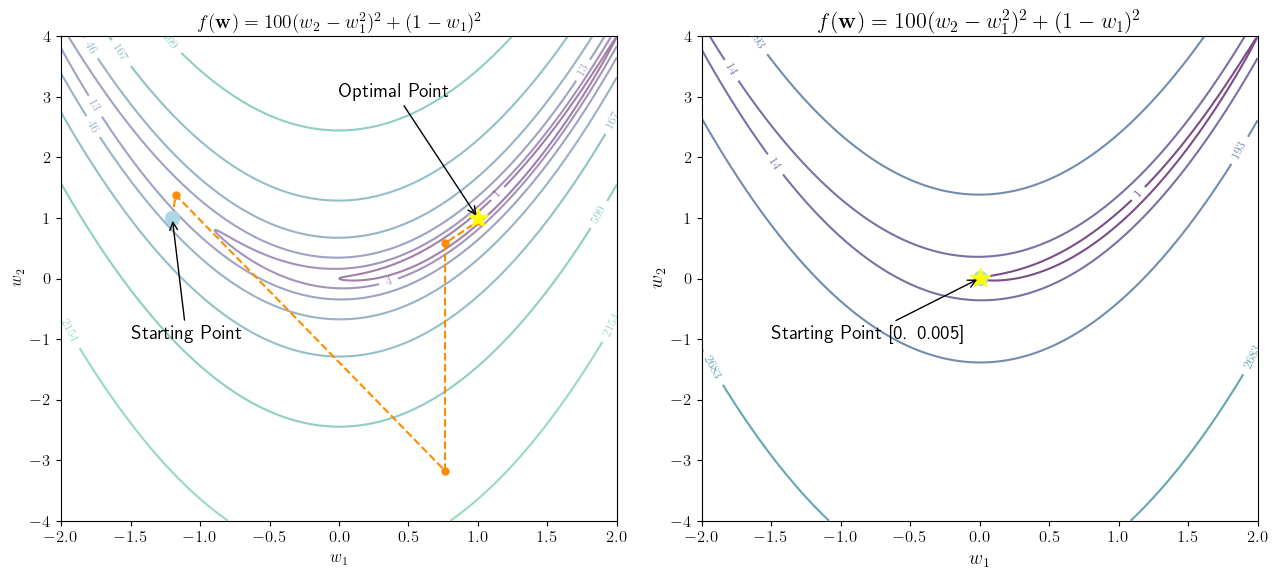

In [6]:
trajectory_a = np.array(stats_a['trajectory'])
trajectory_b = np.array(stats_b['trajectory'])

x = np.linspace(-2, 2, 500)
y = np.linspace(-4, 4, 500)
X, Y = np.meshgrid(x, y)
Z = 100 * (Y - X ** 2) ** 2 + (1 - X) ** 2

fig, ax = plt.subplots(1, 2, figsize=(13, 6))

levels_log_space = np.logspace(0, 5, 10)
cmap_choice = 'viridis'
contour_line_opts = {'linewidths': 0.5, 'colors': 'black'}
contour_label_opts = {'inline': True, 'fontsize': 9}

contour1 = ax[0].contour(X, Y, Z, levels=levels_log_space, norm=LogNorm(), cmap=cmap_choice, alpha=0.5)
ax[0].clabel(contour1, **contour_label_opts)
ax[0].plot(*trajectory_a.T, 'o--', color='darkorange', markersize=5, label='Trajectory')
ax[0].plot(*trajectory_a[0], 'o', color='lightblue', markersize=10, label='Starting Point')
ax[0].plot(*final_point_a, '*', color='yellow', markersize=15, label='Optimal Point')
ax[0].annotate('Starting Point', xy=trajectory_a[0], xytext=(-1.5, -1),
               arrowprops=dict(facecolor='black', arrowstyle='->'))
ax[0].annotate('Optimal Point', xy=final_point_a, xytext=(0, 3),
               arrowprops=dict(facecolor='black', arrowstyle='->'))
ax[0].set_title(r"$f(\mathbf{w}) = 100(w_2 - w_1^2)^2 + (1 - w_1)^2$", fontsize=14)
ax[0].set_xlabel('$w_1$', fontsize=12)
ax[0].set_ylabel('$w_2$', fontsize=12)

contour2 = ax[1].contour(X, Y, Z, levels=np.logspace(0, 8, 8), norm=LogNorm(), cmap=cmap_choice, alpha=0.7)
ax[1].clabel(contour2, **contour_label_opts)
ax[1].plot(*trajectory_b.T, 'o--', color='darkorange', markersize=5, label='Trajectory')
ax[1].plot(*trajectory_b[0], 'o', color='lightblue', markersize=10, label='Starting Point')
ax[1].plot(*final_point_b, '*', color='yellow', markersize=15, label='Optimal Point')
ax[1].annotate(f'Starting Point {initial_points[1]}', xy=trajectory_b[0], xytext=(-1.5, -1),
               arrowprops=dict(facecolor='black', arrowstyle='->'))
ax[1].set_title(r"$f(\mathbf{w}) = 100(w_2 - w_1^2)^2 + (1 - w_1)^2$", fontsize=16)
ax[1].set_xlabel('$w_1$', fontsize=14)
ax[1].set_ylabel('$w_2$', fontsize=14)

plt.tight_layout()
plt.savefig('rosenbrock.pdf', bbox_inches='tight')
plt.show()

In [7]:
glnewton_a = GlobalizedNewtonsOptimizer(rosenbrock, grad_rosenbrock, hess_rosenbrock, initial_points[0], verbose=True,
                                        c=0.0001, theta=0.5)
glnewton_b = GlobalizedNewtonsOptimizer(rosenbrock, grad_rosenbrock, hess_rosenbrock, initial_points[1], verbose=True,
                                        c=0.0001, theta=0.5)

final_point_a, stats_a = glnewton_a.solve()
final_point_b, stats_b = glnewton_b.solve()

trajectory_a = np.array(stats_a['trajectory'])
trajectory_b = np.array(stats_b['trajectory'])

Starting optimization!
Iteration 1:
	Current point: [-1.1752809   1.38067416]
	Function value: 4.731884325262316
	Gradient norm: 4.6394262142690135
Iteration 2:
	Current point: [-0.93298143  0.81121066]
	Function value: 4.087398661766703
	Gradient norm: 28.55008044862973
Iteration 3:
	Current point: [-0.78254008  0.58973638]
	Function value: 3.2286725887687853
	Gradient norm: 11.571520884687654
Iteration 4:
	Current point: [-0.45999712  0.10756339]
	Function value: 3.2138980841221834
	Gradient norm: 30.325894452770026
Iteration 5:
	Current point: [-0.39304563  0.15000237]
	Function value: 1.9425854216447604
	Gradient norm: 3.604102263725408
Iteration 6:
	Current point: [-0.20941191  0.00677013]
	Function value: 1.600193694498068
	Gradient norm: 9.248418327055214
Iteration 7:
	Current point: [-0.06571902 -0.01632866]
	Function value: 1.1783895624497365
	Gradient norm: 4.919800731465925
Iteration 8:
	Current point: [ 0.14204254 -0.02298878]
	Function value: 0.9224115779594502
	Gradient n

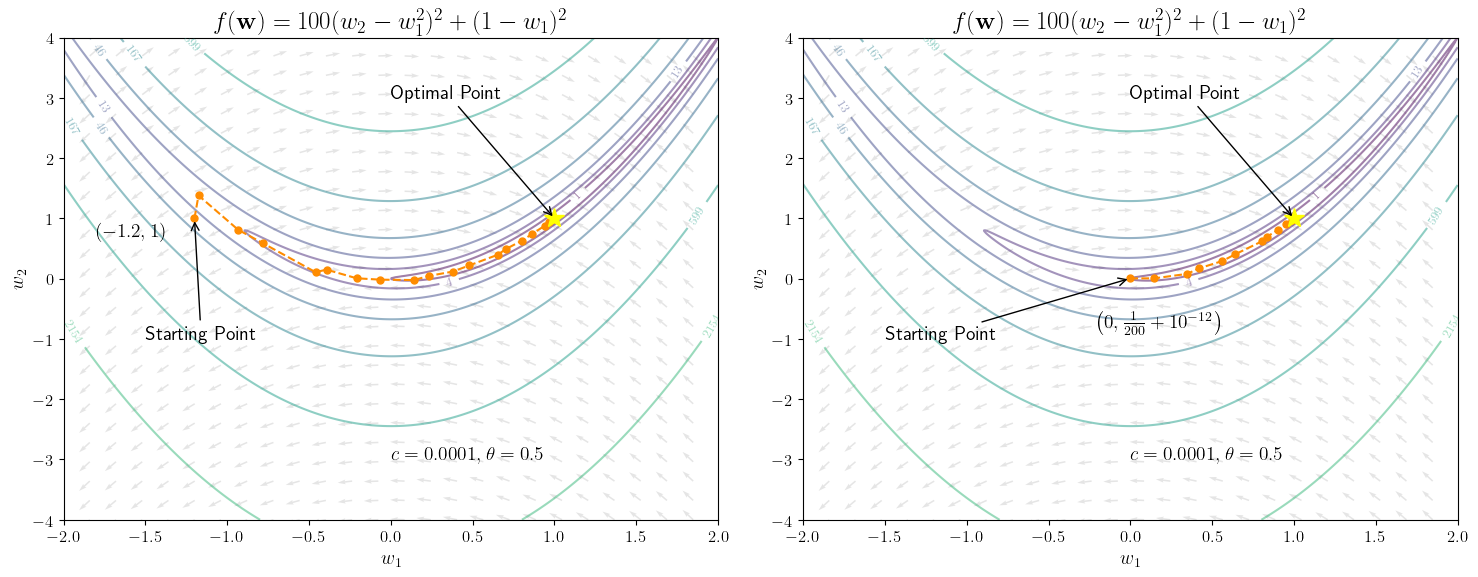

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
x = np.linspace(-2, 2, 500)
y = np.linspace(-4, 4, 500)
X, Y = np.meshgrid(x, y)
Z = 100 * (Y - X ** 2) ** 2 + (1 - X) ** 2

U, V = np.gradient(Z, x, y)
norm = np.sqrt(U ** 2 + V ** 2)
U, V = U / norm, V / norm
quiver_skip = 20

trajectories = [(trajectory_a, final_point_a, initial_points[0]), (trajectory_b, final_point_b, initial_points[1])]
for i, (trajectory, final_point, initial_point) in enumerate(trajectories):
    contour = ax[i].contour(X, Y, Z, levels=np.logspace(0, 5, 10), norm=LogNorm(), cmap='viridis', alpha=0.5)
    ax[i].clabel(contour, inline=True, fontsize=9)
    ax[i].plot([pt[0] for pt in trajectory], [pt[1] for pt in trajectory], 'o--', color='darkorange', markersize=5)
    ax[i].plot(final_point[0], final_point[1], '*', color='yellow', markersize=15)
    ax[i].annotate('Starting Point', xy=initial_point, xytext=(-1.5, -1),
                   arrowprops=dict(facecolor='black', arrowstyle='->'))
    ax[i].annotate('Optimal Point', xy=final_point, xytext=(0, 3),
                   arrowprops=dict(facecolor='black', arrowstyle='->'))
    ax[i].quiver(X[::quiver_skip, ::quiver_skip], Y[::quiver_skip, ::quiver_skip],
                 U[::quiver_skip, ::quiver_skip], V[::quiver_skip, ::quiver_skip],
                 color='grey', alpha=0.2, scale=45, zorder=1)

    ax[i].set_title(r"$f(\mathbf{w}) = 100(w_2 - w_1^2)^2 + (1 - w_1)^2$", fontsize=18)
    ax[i].set_xlabel('$w_1$')
    ax[i].set_ylabel('$w_2$')

ax[0].annotate(r'$c=0.0001, \theta=0.5$', xy=(0, -3), xytext=(0, -3), fontsize=14)
ax[0].annotate(r'$\left(-1.2, 1\right)$', xy=(-1.2, 1), xytext=(-1.8, 0.7), fontsize=14)
ax[1].annotate(r'$c=0.0001, \theta=0.5$', xy=(0, -3), xytext=(0, -3), fontsize=14)
ax[1].annotate(r'$\left(0, \frac{1}{200} + 10^{-12}\right)$', xy=(0, 0.005), xytext=(-0.2, -0.8), fontsize=14)

plt.tight_layout()
plt.savefig('rosenbrock_globalized.pdf', bbox_inches='tight')
plt.show()

In [9]:
initial_point = np.array([0, 0.005])
c = [0.0001, 0.001, 0.01, 0.1, 0.5]
results_c = {}
for value in c:
    glnewton = GlobalizedNewtonsOptimizer(rosenbrock, grad_rosenbrock, hess_rosenbrock, initial_point, verbose=False,
                                          c=value, theta=0.5)
    final_point, stats = glnewton.solve()
    results_c[value] = (final_point, stats)

theta = [0.1, 0.3, 0.5, 0.7, 0.9]
results_theta = {}
for value in theta:
    glnewton = GlobalizedNewtonsOptimizer(rosenbrock, grad_rosenbrock, hess_rosenbrock, initial_point, verbose=False,
                                          c=0.0001, theta=value)
    final_point, stats = glnewton.solve()
    results_theta[value] = (final_point, stats)

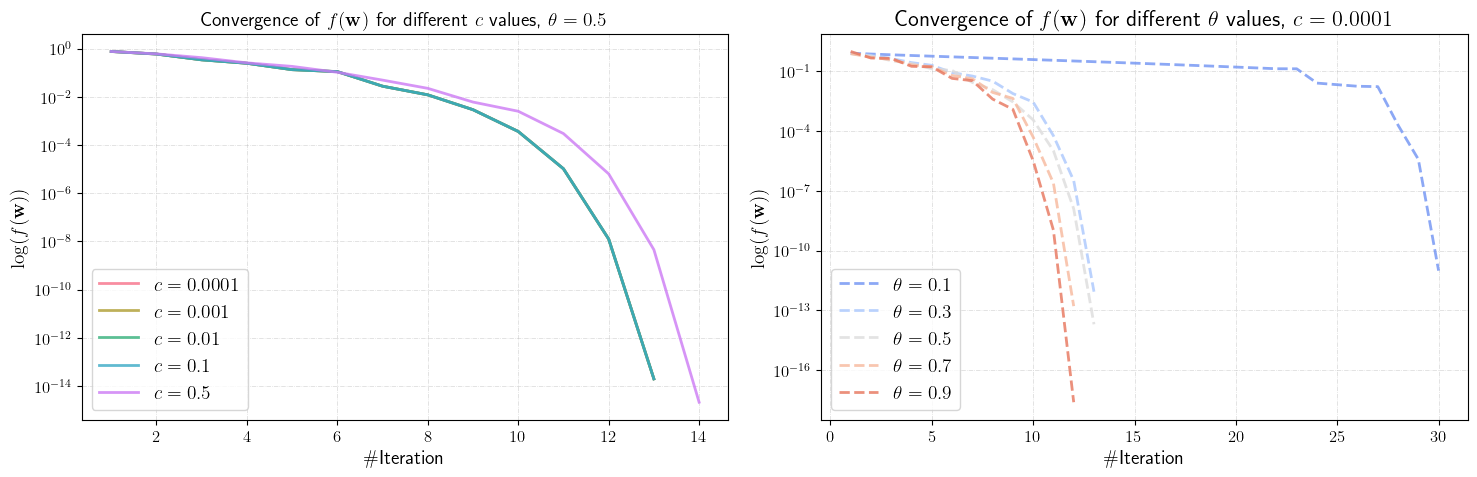

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
colors = sns.color_palette("husl", len(c))
theta_colors = sns.color_palette("coolwarm", len(theta))

for result, c_value, color in zip(results_c.values(), c, colors):
    ax[0].plot([iteration for iteration in range(1, len(result[1]['function_values']) + 1)],
               result[1]['function_values'],
               label=f"$c={c_value}$", linestyle='-', linewidth=2, alpha=0.8, color=color)
ax[0].set_yscale('log')
ax[0].set_xlabel(r'\#Iteration')
ax[0].set_ylabel(r'$\log(f(\mathbf{w}))$')
ax[0].set_title(r'Convergence of $f(\mathbf{w})$ for different $c$ values, $\theta=0.5$', fontsize=14)
ax[0].legend(fontsize=14, loc='lower left')

for result, theta_value, color in zip(results_theta.values(), theta, theta_colors):
    ax[1].plot([iteration for iteration in range(1, len(result[1]['function_values']) + 1)],
               result[1]['function_values'],
               label=f"$\\theta={theta_value}$", linestyle='--', linewidth=2, alpha=0.8, color=color)
ax[1].set_yscale('log')
ax[1].set_xlabel(r'\#Iteration')
ax[1].set_ylabel(r'$\log(f(\mathbf{w}))$')
ax[1].set_title(r'Convergence of $f(\mathbf{w})$ for different $\theta$ values, $c=0.0001$', fontsize=16)
ax[1].legend(fontsize=14, loc='lower left')

for axis in ax:
    axis.grid(True, which='both', linestyle='-.', linewidth=0.5, alpha=0.5)

plt.tight_layout()
plt.savefig('rosenbrock_globalized_c_theta.pdf', bbox_inches='tight')
plt.show()

In [11]:
## RECALL PROBLEM 3

def function(w):
    return 2 * (w[0] + w[1] + w[2] - 3) ** 2 + (w[0] - w[1]) ** 2 + (w[1] - w[2]) ** 2


def grad(w):
    return np.array(
        [6 * w[0] + 2 * w[1] + 4 * w[2] - 12, 2 * w[0] + 8 * w[1] + 2 * w[2] - 12, 4 * w[0] + 2 * w[1] + 6 * w[2] - 12])


def hess(w):
    return np.array([[6, 2, 4], [2, 8, 2], [4, 2, 6]])


start_point = np.array([0, 0, 0])
bgfs = QuasiNewtonBFGSOptimizer(function, grad, start_point, c=0.0001, theta=0.5, verbose=True)
glnewton = GlobalizedNewtonsOptimizer(function, grad, hess, start_point, c=0.0001, theta=0.5, verbose=True)

_, _ = bgfs.solve()
_, _ = glnewton.solve()

Starting optimization!
Iteration 1:
	Current point: [1.5 1.5 1.5]
	Function value: 4.5
	Gradient norm: 10.392304845413264
Iteration 2:
	Current point: [1. 1. 1.]
	Function value: 1.8242408433235898e-30
	Gradient norm: 3.972054645195637e-15
Convergence achieved!
Starting optimization!
Iteration 1:
	Current point: [1. 1. 1.]
	Function value: 5.00000082741607e-21
	Gradient norm: 3.4641019017588074e-10
Convergence achieved!


In [12]:
start_point = np.array([-1.2, 1])
bgfs = QuasiNewtonBFGSOptimizer(rosenbrock, grad_rosenbrock, start_point, c=0.0001, theta=0.5, verbose=True)
glnewton = GlobalizedNewtonsOptimizer(rosenbrock, grad_rosenbrock, hess_rosenbrock, start_point, c=0.0001, theta=0.5,
                                      verbose=True)

final_point_bgfs, stats_bgfs = bgfs.solve()
final_point_glnewton, stats_glnewton = glnewton.solve()

Starting optimization!
Iteration 1:
	Current point: [-0.98945312  1.0859375 ]
	Function value: 5.101112663710957
	Gradient norm: 43.89852092322499
Iteration 2:
	Current point: [-0.77234581  0.5705924 ]
	Function value: 3.208423566374003
	Gradient norm: 12.66424833955317
Iteration 3:
	Current point: [-0.74128547  0.51842587]
	Function value: 3.1286610193291233
	Gradient norm: 14.13741465248728
Iteration 4:
	Current point: [-0.46315776  0.1417113 ]
	Function value: 2.670870141965106
	Gradient norm: 21.941763266061873
Iteration 5:
	Current point: [-0.49759059  0.26729175]
	Function value: 2.2815682921264018
	Gradient norm: 4.046201510838804
Iteration 6:
	Current point: [-0.38197111  0.13390899]
	Function value: 1.9242272299326313
	Gradient norm: 5.184538351739119
Iteration 7:
	Current point: [-0.3047509   0.05829363]
	Function value: 1.8219489730071452
	Gradient norm: 9.716320442462425
Iteration 8:
	Current point: [-0.2616586   0.03613685]
	Function value: 1.6962947712445997
	Gradient nor

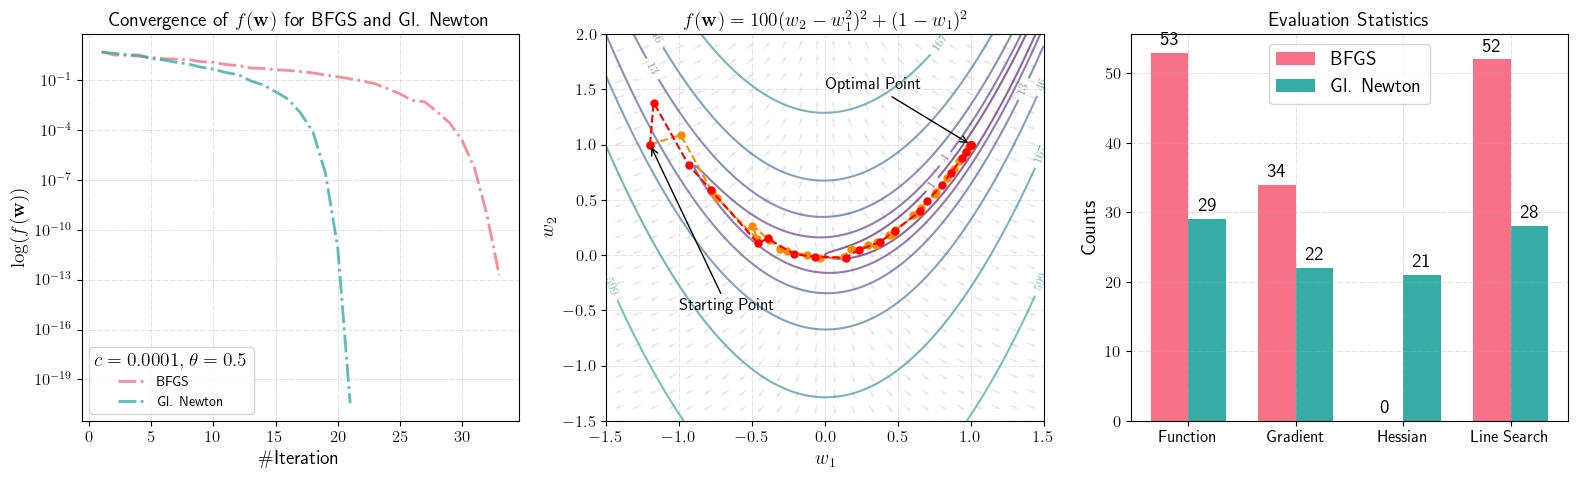

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(16, 5))
colors = sns.color_palette("husl", 2)

for result, method, color in zip([stats_bgfs, stats_glnewton], ['BFGS', 'Gl. Newton'], colors):
    ax[0].plot([iteration for iteration in range(1, len(result['function_values']) + 1)],
               result['function_values'],
               label=method, linestyle='-.', linewidth=2, alpha=0.8, color=color)
ax[0].set_yscale('log')
ax[0].set_xlabel(r'\#Iteration')
ax[0].set_ylabel(r'$\log(f(\mathbf{w}))$')
ax[0].set_title(r'Convergence of $f(\mathbf{w})$ for BFGS and Gl. Newton', fontsize=14)
ax[0].legend(fontsize=10, loc='lower left', title=r'$c=0.0001, \theta=0.5$')

x = np.linspace(-1.5, 1.5, 500)
y = np.linspace(-1.5, 2, 500)
X, Y = np.meshgrid(x, y)
Z = 100 * (Y - X ** 2) ** 2 + (1 - X) ** 2

U, V = np.zeros(X.shape), np.zeros(Y.shape)

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        grad = grad_rosenbrock(np.array([X[i, j], Y[i, j]]))
        U[i, j] = grad[0]
        V[i, j] = grad[1]

norm = np.sqrt(U ** 2 + V ** 2)
U /= norm
V /= norm
quiver_skip = 20

contour = ax[1].contour(X, Y, Z, levels=np.logspace(0, 5, 10), norm=LogNorm(), cmap='viridis', alpha=0.6)
ax[1].clabel(contour, inline=True, fontsize=9)
ax[1].plot([x[0] for x in stats_bgfs['trajectory']], [x[1] for x in stats_bgfs['trajectory']], 'o--',
           color='darkorange', markersize=5, label='BFGS')
ax[1].plot([x[0] for x in stats_glnewton['trajectory']], [x[1] for x in stats_glnewton['trajectory']], 'o--',
           color='red', markersize=5, label='Gl. Newton')
ax[1].quiver(X[::quiver_skip, ::quiver_skip], Y[::quiver_skip, ::quiver_skip],
             U[::quiver_skip, ::quiver_skip], V[::quiver_skip, ::quiver_skip],
             color='grey', alpha=0.2, scale=45, zorder=1)
ax[1].annotate('Starting Point', xy=start_point, xytext=(-1, -0.5),
               arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=12)
ax[1].annotate('Optimal Point', xy=final_point_bgfs, xytext=(0, 1.5),
               arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=12)
ax[1].set_title(r"$f(\mathbf{w}) = 100(w_2 - w_1^2)^2 + (1 - w_1)^2$", fontsize=14)
ax[1].set_xlabel('$w_1$')
ax[1].set_ylabel('$w_2$')
for axis in ax:
    axis.grid(True, which='both', linestyle='-.', linewidth=0.5, alpha=0.5)

stats_categories = ['Function', 'Gradient', 'Hessian', 'Line Search']
x = np.arange(len(stats_categories))
width = 0.35

stats_bfgs = [stats_bgfs['function_evaluations'], stats_bgfs['gradient_evaluations'], 0, stats_bgfs['line_search_step']]

stats_newton = [stats_glnewton['function_evaluations'], stats_glnewton['gradient_evaluations'],
                stats_glnewton['hessian_evaluations'], stats_glnewton['line_search_step']]

rects1 = ax[2].bar(x - width / 2, stats_bfgs, width, label='BFGS', color=colors[0])
rects2 = ax[2].bar(x + width / 2, stats_newton, width, label='Gl. Newton', color=colors[1])

ax[2].set_ylabel('Counts')
ax[2].set_title('Evaluation Statistics')
ax[2].set_xticks(x)
ax[2].set_xticklabels(stats_categories, fontsize=12)
ax[2].legend()


def autolabel(rects, ax):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1, ax[2])
autolabel(rects2, ax[2])

plt.tight_layout()
plt.savefig('rosenbrock_bfgs_vs_newton.pdf', bbox_inches='tight')
plt.show()

In [14]:
start_point = np.array([-1.2, 1])
c, theta, tolerance, max_iterations = 0.0001, 0.5, 1e-4, 10000

bfgs = QuasiNewtonBFGSOptimizer(rosenbrock, grad_rosenbrock, start_point, c=c, theta=theta, verbose=True)
lbfgs_0 = LBFGSOptimizer(rosenbrock, grad_rosenbrock, start_point, memory_size=0, c=c, theta=theta, verbose=True)
lbfgs_1 = LBFGSOptimizer(rosenbrock, grad_rosenbrock, start_point, memory_size=1, c=c, theta=theta, verbose=True)
lbfgs_5 = LBFGSOptimizer(rosenbrock, grad_rosenbrock, start_point, memory_size=5, c=c, theta=theta, verbose=True)
lbfgs_10 = LBFGSOptimizer(rosenbrock, grad_rosenbrock, start_point, memory_size=10, c=c, theta=theta, verbose=True)

final_point_bfgs, stats_bfgs = bfgs.solve(tolerance=tolerance, max_iterations=max_iterations)
final_point_lbfgs_0, stats_lbfgs_0 = lbfgs_0.solve(tolerance=tolerance, max_iterations=max_iterations)
final_point_lbfgs_1, stats_lbfgs_1 = lbfgs_1.solve(tolerance=tolerance, max_iterations=max_iterations)
final_point_lbfgs_5, stats_lbfgs_5 = lbfgs_5.solve(tolerance=tolerance, max_iterations=max_iterations)
final_point_lbfgs_10, stats_lbfgs_10 = lbfgs_10.solve(tolerance=tolerance, max_iterations=max_iterations)

Starting optimization!
Iteration 1:
	Current point: [-0.98945312  1.0859375 ]
	Function value: 5.101112663710957
	Gradient norm: 43.89852092322499
Iteration 2:
	Current point: [-0.77234581  0.5705924 ]
	Function value: 3.208423566374003
	Gradient norm: 12.66424833955317
Iteration 3:
	Current point: [-0.74128547  0.51842587]
	Function value: 3.1286610193291233
	Gradient norm: 14.13741465248728
Iteration 4:
	Current point: [-0.46315776  0.1417113 ]
	Function value: 2.670870141965106
	Gradient norm: 21.941763266061873
Iteration 5:
	Current point: [-0.49759059  0.26729175]
	Function value: 2.2815682921264018
	Gradient norm: 4.046201510838804
Iteration 6:
	Current point: [-0.38197111  0.13390899]
	Function value: 1.9242272299326313
	Gradient norm: 5.184538351739119
Iteration 7:
	Current point: [-0.3047509   0.05829363]
	Function value: 1.8219489730071452
	Gradient norm: 9.716320442462425
Iteration 8:
	Current point: [-0.2616586   0.03613685]
	Function value: 1.6962947712445997
	Gradient nor

In [15]:
table = PrettyTable()
table.field_names = ["Optimizer", "Function Evaluations", "Gradient Evaluations", "Hessian Evaluations",
                     "Line Search Steps", "Iterations"]

table.add_row(["BFGS", stats_bfgs['function_evaluations'], stats_bfgs['gradient_evaluations'], 0,
               stats_bfgs['line_search_step'], stats_bfgs['iterations']])
table.add_row(["L-BFGS (m=0)", stats_lbfgs_0['function_evaluations'], stats_lbfgs_0['gradient_evaluations'], 0,
               stats_lbfgs_0['line_search_step'], stats_lbfgs_0['iterations']])
table.add_row(["L-BFGS (m=1)", stats_lbfgs_1['function_evaluations'], stats_lbfgs_1['gradient_evaluations'], 0,
               stats_lbfgs_1['line_search_step'], stats_lbfgs_1['iterations']])
table.add_row(["L-BFGS (m=5)", stats_lbfgs_5['function_evaluations'], stats_lbfgs_5['gradient_evaluations'], 0,
               stats_lbfgs_5['line_search_step'], stats_lbfgs_5['iterations']])
table.add_row(["L-BFGS (m=10)", stats_lbfgs_10['function_evaluations'], stats_lbfgs_10['gradient_evaluations'], 0,
               stats_lbfgs_10['line_search_step'], stats_lbfgs_10['iterations']])
print(table)

+---------------+----------------------+----------------------+---------------------+-------------------+------------+
|   Optimizer   | Function Evaluations | Gradient Evaluations | Hessian Evaluations | Line Search Steps | Iterations |
+---------------+----------------------+----------------------+---------------------+-------------------+------------+
|      BFGS     |          53          |          34          |          0          |         52        |     33     |
|  L-BFGS (m=0) |        80045         |         8059         |          0          |       80044       |    8058    |
|  L-BFGS (m=1) |         368          |          43          |          0          |        367        |     42     |
|  L-BFGS (m=5) |          65          |          36          |          0          |         64        |     35     |
| L-BFGS (m=10) |          52          |          33          |          0          |         51        |     32     |
+---------------+----------------------+--------

In [16]:
###############################################################################
#            THIS CODE HAS BEEN TAKEN FROM LAB 4 OF THE COURSE                 #
#            "OPTIMIZATION FOR MACHINE LEARNING" IASD                          #
###############################################################################

import numpy as np
from numpy.linalg import norm
from scipy.linalg import svdvals
from scipy.linalg import toeplitz
from numpy.random import multivariate_normal, randn


class RegPb(object):
    def __init__(self, X, y, lbda=0, loss='l2'):
        self.X = X
        self.y = y
        self.n, self.d = X.shape
        self.loss = loss
        self.lbda = lbda

    # Objective value
    def fun(self, w):
        if self.loss == 'l2':
            return norm(self.X.dot(w) - self.y) ** 2 / (2. * self.n) + self.lbda * norm(w) ** 2 / 2.
        elif self.loss == 'logit':
            yXw = self.y * self.X.dot(w)
            return np.mean(np.log(1. + np.exp(-yXw))) + self.lbda * norm(w) ** 2 / 2.

    # Partial objective value
    def f_i(self, i, w):
        if self.loss == 'l2':
            return norm(self.X[i].dot(w) - self.y[i]) ** 2 / (2.) + self.lbda * norm(w) ** 2 / 2.
        elif self.loss == 'logit':
            yXwi = self.y[i] * np.dot(self.X[i], w)
            return np.log(1. + np.exp(- yXwi)) + self.lbda * norm(w) ** 2 / 2.

    # Full gradient computation
    def grad(self, w):
        if self.loss == 'l2':
            return self.X.T.dot(self.X.dot(w) - self.y) / self.n + self.lbda * w
        elif self.loss == 'logit':
            yXw = self.y * self.X.dot(w)
            aux = 1. / (1. + np.exp(yXw))
            return - (self.X.T).dot(self.y * aux) / self.n + self.lbda * w

    # Hessian (Quyen Linh TA)
    def hess(self, w):
        if self.loss == 'l2':
            return self.X.T.dot(self.X) / self.n + self.lbda * np.eye(self.d)
        elif self.loss == 'logit':
            yXw = self.y * self.X.dot(w)
            aux = 1. / (1. + np.exp(yXw))
            D = np.diag(aux * (1. - aux))
            return self.X.T.dot(D).dot(self.X) / self.n + self.lbda * np.eye(self.d)

    # Partial gradient
    def grad_i(self, i, w):
        x_i = self.X[i]
        if self.loss == 'l2':
            return (x_i.dot(w) - self.y[i]) * x_i + self.lbda * w
        elif self.loss == 'logit':
            grad = - x_i * self.y[i] / (1. + np.exp(self.y[i] * x_i.dot(w)))
            grad += self.lbda * w
            return grad

    # Lipschitz constant for the gradient
    def lipgrad(self):
        if self.loss == 'l2':
            L = norm(self.X, ord=2) ** 2 / self.n + self.lbda
        elif self.loss == 'logit':
            L = norm(self.X, ord=2) ** 2 / (4. * self.n) + self.lbda
        return L

    # ''Strong'' convexity constant (could be zero if self.lbda=0)
    def cvxval(self):
        if self.loss == 'l2':
            s = svdvals(self.X)
            mu = min(s) ** 2 / self.n
            return mu + self.lbda
        elif self.loss == 'logit':
            return self.lbda


def simu_linmodel(w, n, std=1., corr=0.5):
    d = w.shape[0]
    cov = toeplitz(corr ** np.arange(0, d))
    X = multivariate_normal(np.zeros(d), cov, size=n)
    noise = std * randn(n)
    y = X.dot(w) + noise
    return X, y


d = 50
n = 1000
idx = np.arange(d)
lbda = 1. / n ** (0.5)

# Fix random seed for reproducibility
np.random.seed(0)

# Ground truth coefficients of the model
w_model_truth = (-1) ** idx * np.exp(-idx / 10.)

Xlin, ylin = simu_linmodel(w_model_truth, n, std=1., corr=0.1)
Xlog, ylog = simu_linmodel(w_model_truth, n, std=1., corr=0.7)
ylog = np.sign(ylog)  # Taking the logarithm for binary classification

pblinreg = RegPb(Xlin, ylin, lbda, loss='l2')
pblogreg = RegPb(Xlog, ylog, lbda, loss='logit')

###############################################################################
#            THIS CODE HAS BEEN TAKEN FROM LAB 4 OF THE COURSE                 #
#            "OPTIMIZATION FOR MACHINE LEARNING" IASD                          #
###############################################################################

In [17]:
objective_fn = pblogreg.fun
gradient_fn = pblogreg.grad
hessian_fn = pblogreg.hess

In [18]:
initial_point = np.zeros(d)
newton = NewtonsMethodOptimizer(objective_fn, gradient_fn, hessian_fn, initial_point, verbose=True)
final_point, stats = newton.solve(tolerance=1e-6, max_iterations=1000)

Starting optimization!
Iteration 1:
	Current point: [ 0.76753246 -0.64675296  0.51062364 -0.43169322  0.47907758 -0.36623262
  0.32944811 -0.2578968   0.2154468  -0.26511072  0.3075745  -0.14543
  0.10810184 -0.13083114  0.08997055 -0.11834883  0.0690123  -0.04458564
  0.1122789  -0.17524301  0.04618596 -0.0660032   0.17841093 -0.04252745
 -0.14555565  0.04925993  0.05856531 -0.090995    0.06610178 -0.02099218
  0.0388914  -0.08868872  0.02001951 -0.07051862  0.06072219  0.06238814
  0.06893325 -0.10391071  0.03199462 -0.02648561  0.01759083 -0.05899996
  0.00708312 -0.00937315 -0.0709923   0.14766245  0.0573895  -0.06327165
 -0.00216302  0.09440565]
	Function value: 0.5635498130008357
	Gradient norm: 0.025229719282381626
Iteration 2:
	Current point: [ 0.86632541 -0.71149763  0.55883124 -0.46824772  0.52956161 -0.40261392
  0.36289885 -0.28646309  0.23162492 -0.28139304  0.3365905  -0.15909223
  0.11762491 -0.14551662  0.09777394 -0.12771508  0.07371798 -0.04360977
  0.11691632 -0.1915

In [19]:
class BaseOptimizer:
    def __init__(self, problem, theta=0.5, c=1e-4, alpha=0.01):
        self.problem = problem
        self.theta = theta
        self.c = c
        self.alpha = alpha
        self.stats = {'losses': [], 'epochs': []}

    def armijo_line_search(self, w, d, grad_f_w, sample_indices=None):
        alpha = self.alpha
        f_w = self.problem.fun(w) if sample_indices is None else np.mean(
            [self.problem.f_i(i, w) for i in sample_indices])
        for _ in range(100):
            w_new = w + alpha * d
            f_w_new = self.problem.fun(w_new) if sample_indices is None else np.mean(
                [self.problem.f_i(i, w_new) for i in sample_indices])
            condition = f_w + self.c * alpha * np.dot(grad_f_w.T, d)
            if f_w_new <= condition:
                break
            alpha *= self.theta
        return alpha

    def optimize(self, w_init, tol=1e-6):
        raise NotImplementedError("This method should be implemented by subclasses.")


class SubsamplingNewton(BaseOptimizer):
    def __init__(self, problem, sample_size_grad, sample_size_hess, epochs, theta=0.9, c=1e-4, alpha=0.001,
                 lambda_reg=1. / 1000 ** (0.5)):
        super().__init__(problem, theta, c, alpha)
        self.sample_size_grad = sample_size_grad
        self.sample_size_hess = sample_size_hess
        self.epochs = epochs
        self.lambda_reg = lambda_reg

    def hess_i(self, i, w):
        X_i = self.problem.X[i]
        n_features = X_i.shape[0]
        H_i = 2 * np.outer(X_i, X_i) + 2 * self.lambda_reg * np.eye(n_features)
        return H_i

    def optimize(self, w_init, tol=1e-6, use_line_search=True):
        self.stats = {'losses': [], 'epochs': []}
        w = w_init.copy()
        n_samples = self.problem.n
        batch_per_epoch = max(n_samples // min(self.sample_size_grad, self.sample_size_hess), 1)

        for epoch in range(self.epochs):
            with tqdm(total=batch_per_epoch, desc=f"Epoch {epoch + 1}") as epoch_progress:
                for batch in range(batch_per_epoch):
                    grad_indices = np.random.choice(n_samples, self.sample_size_grad, replace=False)
                    hess_indices = np.random.choice(n_samples, self.sample_size_hess, replace=False)

                    grad = np.mean([self.problem.grad_i(i, w) for i in grad_indices], axis=0)
                    H = np.mean([self.hess_i(i, w) for i in hess_indices], axis=0)

                    d = -np.linalg.solve(H, grad)

                    if use_line_search:
                        alpha = self.armijo_line_search(w, d, grad, grad_indices)
                    else:
                        alpha = self.alpha

                    w += alpha * d
                    epoch_progress.update(1)

                current_loss = self.problem.fun(w)
                epoch_progress.set_postfix({'Loss': f'{current_loss:.4f}'})
                self.stats['losses'].append(current_loss)
                self.stats['epochs'].append(epoch + 1)
        return w, self.stats


class StochasticBFGS(BaseOptimizer):
    def __init__(self, problem, sample_size, epochs, theta=0.5, c=1e-4, alpha=0.01):
        super().__init__(problem, theta, c, alpha)
        self.sample_size = sample_size
        self.epochs = epochs

    def optimize(self, w_init, tol=1e-6, use_line_search=True):
        self.stats = {'losses': [], 'epochs': []}
        w = w_init.copy()
        I = np.eye(len(w))
        H = I  # Initial approximation of the inverse Hessian

        n_samples = self.problem.n
        batch_per_epoch = max(n_samples // self.sample_size, 1)

        for epoch in range(self.epochs):
            with tqdm(total=batch_per_epoch, desc=f"Epoch {epoch + 1}") as epoch_progress:
                for _ in range(batch_per_epoch):
                    sample_indices = np.random.choice(n_samples, self.sample_size, replace=False)
                    grad = np.mean([self.problem.grad_i(i, w) for i in sample_indices], axis=0)

                    # BFGS update
                    w_prev = w.copy()
                    grad_prev = grad.copy()

                    # Choose direction
                    d = -H.dot(grad)

                    # Line search
                    if use_line_search:
                        alpha = self.armijo_line_search(w, d, grad, sample_indices)
                    else:
                        alpha = self.alpha

                    # Update w
                    w += alpha * d

                    # Update H
                    s = alpha * d
                    grad = np.mean([self.problem.grad_i(i, w) for i in sample_indices], axis=0)
                    y = grad - grad_prev
                    rho = 1.0 / np.dot(y.T, s)

                    if np.dot(y.T, s) > 0:  # To ensure the update is well-defined
                        H = (I - rho * np.outer(s, y)).dot(H).dot(I - rho * np.outer(y, s)) + rho * np.outer(s, s)

                    epoch_progress.update(1)

                current_loss = np.mean([self.problem.f_i(i, w) for i in sample_indices])
                epoch_progress.set_postfix({'Loss': f'{current_loss:.4f}'})
                self.stats['losses'].append(current_loss)
                self.stats['epochs'].append(epoch + 1)

        return w, self.stats


class StochasticLBFGS(BaseOptimizer):
    def __init__(self, problem, sample_size, epochs, m=5, theta=0.5, c=1e-4, alpha=0.01):
        super().__init__(problem, theta, c, alpha)
        self.sample_size = sample_size
        self.epochs = epochs
        self.m = m

    def optimize(self, w_init, tol=1e-6, use_line_search=True):
        self.stats = {'losses': [], 'epochs': []}
        w = w_init.copy()
        n = len(w)

        if self.m > 0:
            S = np.zeros((n, self.m))
            Y = np.zeros((n, self.m))
            rho = np.zeros(self.m)
        alpha_i = np.zeros(max(self.m, 1))  # Ensure at least size 1 for the case m=0
        q = np.zeros(n)

        n_samples = self.problem.n
        batch_per_epoch = max(n_samples // self.sample_size, 1)
        k = 0  # Iteration counter for circular buffers

        for epoch in range(self.epochs):
            with tqdm(total=batch_per_epoch, desc=f"Epoch {epoch + 1}") as epoch_progress:
                for _ in range(batch_per_epoch):
                    sample_indices = np.random.choice(n_samples, self.sample_size, replace=False)
                    grad = np.mean([self.problem.grad_i(i, w) for i in sample_indices], axis=0)

                    if self.m > 0:
                        q[:] = grad
                        for i in range(min(k, self.m)):
                            idx = (k - i - 1) % self.m
                            alpha_i[idx] = rho[idx] * S[:, idx].dot(q)
                            q -= alpha_i[idx] * Y[:, idx]

                        if k > 0:
                            gamma = S[:, (k - 1) % self.m].dot(Y[:, (k - 1) % self.m]) / Y[:, (k - 1) % self.m].dot(
                                Y[:, (k - 1) % self.m])
                            H0 = gamma * np.eye(n)
                        else:
                            H0 = np.eye(n)

                        r = H0.dot(q)
                        for i in range(min(k, self.m)):
                            idx = (k - i - 1) % self.m
                            beta = rho[idx] * Y[:, idx].dot(r)
                            r += S[:, idx] * (alpha_i[idx] - beta)

                        d = -r
                    else:
                        # Fallback to simple gradient descent if m=0
                        d = -grad

                    # Line search or fixed step size
                    step_size = self.alpha if not use_line_search else self.armijo_line_search(w, d, grad,
                                                                                               sample_indices)

                    # Update w
                    s = step_size * d
                    w += s

                    if self.m > 0:
                        # Update gradients, S, Y, and rho
                        new_grad = np.mean([self.problem.grad_i(i, w) for i in sample_indices], axis=0)
                        y = new_grad - grad
                        if np.dot(y, s) > 0:  # Ensure update is well-defined
                            rho[k % self.m] = 1.0 / np.dot(y, s)
                            S[:, k % self.m] = s
                            Y[:, k % self.m] = y
                            k += 1

                    epoch_progress.update(1)

                current_loss = np.mean([self.problem.f_i(i, w) for i in sample_indices])
                epoch_progress.set_postfix({'Loss': f'{current_loss:.4f}'})
                self.stats['losses'].append(current_loss)
                self.stats['epochs'].append(epoch + 1)

        return w, self.stats

In [20]:
problem = pblogreg
sample_size_grad = sample_size_hess = 128

newton = SubsamplingNewton(problem, sample_size_grad, sample_size_hess, epochs=200, theta=0.5, c=1e-4, alpha=0.01)
final_point = newton.optimize(initial_point, tol=1e-6, use_line_search=False)

Epoch 200: 100%|██████████| 7/7 [00:00<00:00, 138.30it/s, Loss=0.5632]


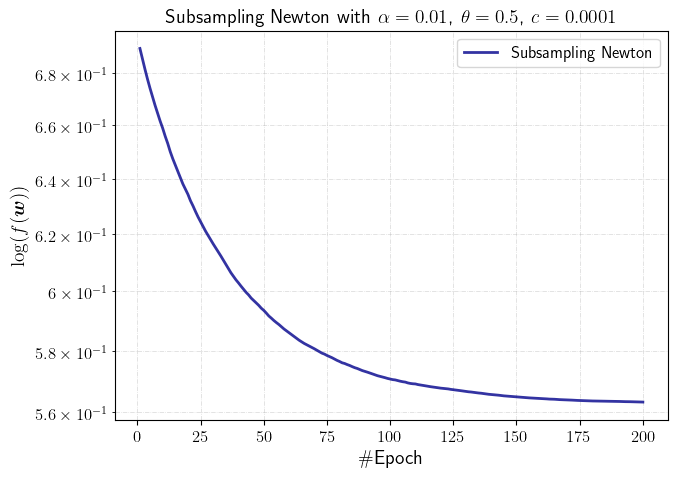

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.plot(newton.stats['epochs'], newton.stats['losses'],
        label='Subsampling Newton', linestyle='-', linewidth=2, alpha=0.8, color='darkblue')
ax.set_yscale('log')
ax.set_xlabel(r'\#Epoch')
ax.set_ylabel(r'$\log(f(\boldsymbol{w}))$')
ax.set_title(r'Subsampling Newton with $\alpha={}$, $\theta={}$, $c={}$'.format(newton.alpha, newton.theta, newton.c))
ax.legend(fontsize=12)
ax.grid(True, which='both', linestyle='-.', linewidth=0.5, alpha=0.5)
plt.tight_layout()
plt.savefig('subsampling_newton.pdf', bbox_inches='tight')
plt.show()

In [22]:
sample_sizes = [16, 32, 64, 128, 256]
results = {}
for sample_size in sample_sizes:
    newton = SubsamplingNewton(problem, sample_size, sample_size, epochs=200, theta=0.5, c=1e-4, alpha=0.01)
    final_point, stats = newton.optimize(initial_point, tol=1e-6, use_line_search=True)
    results[sample_size] = (final_point, stats)

Epoch 200: 100%|██████████| 3/3 [00:00<00:00, 48.44it/s, Loss=0.5803]


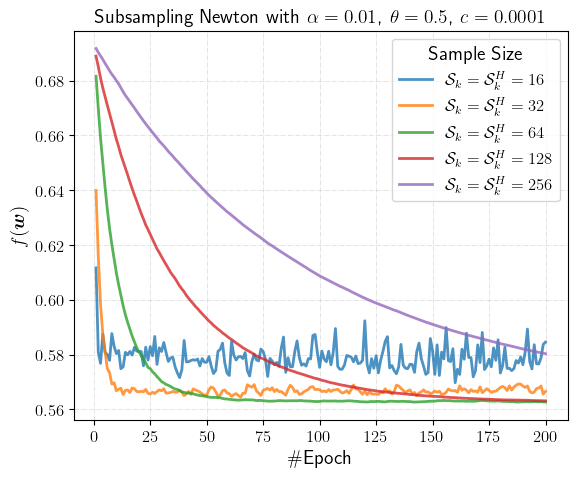

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
for sample_size, (final_point, stats) in results.items():
    ax.plot(stats['epochs'], stats['losses'],
            label=r"$\mathcal{{S}}_{{k}}=\mathcal{{S}}_{{k}}^{{H}}={}$".format(sample_size),
            linestyle='-', linewidth=2, alpha=0.8)
ax.set_xlabel(r'\#Epoch')
ax.set_ylabel(r'$f(\boldsymbol{w})$')
ax.set_title(r'Subsampling Newton with $\alpha={}$, $\theta={}$, $c={}$'.format(newton.alpha, newton.theta, newton.c))
ax.legend(fontsize=12, title='Sample Size')
ax.grid(True, which='both', linestyle='-.', linewidth=0.5, alpha=0.5)
plt.tight_layout()
plt.savefig('subsampling_newton_sample_sizes.pdf', bbox_inches='tight')
plt.show()

In [24]:
# TIME CONSUMING ETA 14min FOR ALL COMBINATIONS

sample_size_grad = [32, 64, 128, 256]
sample_size_hess = [32, 64, 128, 256]

results_diff_grad_32, results_diff_grad_64, results_diff_grad_128, results_diff_grad_256 = {}, {}, {}, {}
for size_grad in sample_size_grad:
    for size_hess in sample_size_hess:
        if size_grad != size_hess:
            newton = SubsamplingNewton(problem, size_grad, size_hess, epochs=200, theta=0.5, c=1e-4, alpha=0.01)
            final_point, stats = newton.optimize(initial_point, tol=1e-6, use_line_search=True)
            if size_grad == 32:
                results_diff_grad_32[(size_grad, size_hess)] = (final_point, stats)
            elif size_grad == 64:
                results_diff_grad_64[(size_grad, size_hess)] = (final_point, stats)
            elif size_grad == 128:
                results_diff_grad_128[(size_grad, size_hess)] = (final_point, stats)
            elif size_grad == 256:
                results_diff_grad_256[(size_grad, size_hess)] = (final_point, stats)

Epoch 200: 100%|██████████| 7/7 [00:00<00:00, 53.03it/s, Loss=0.5630]


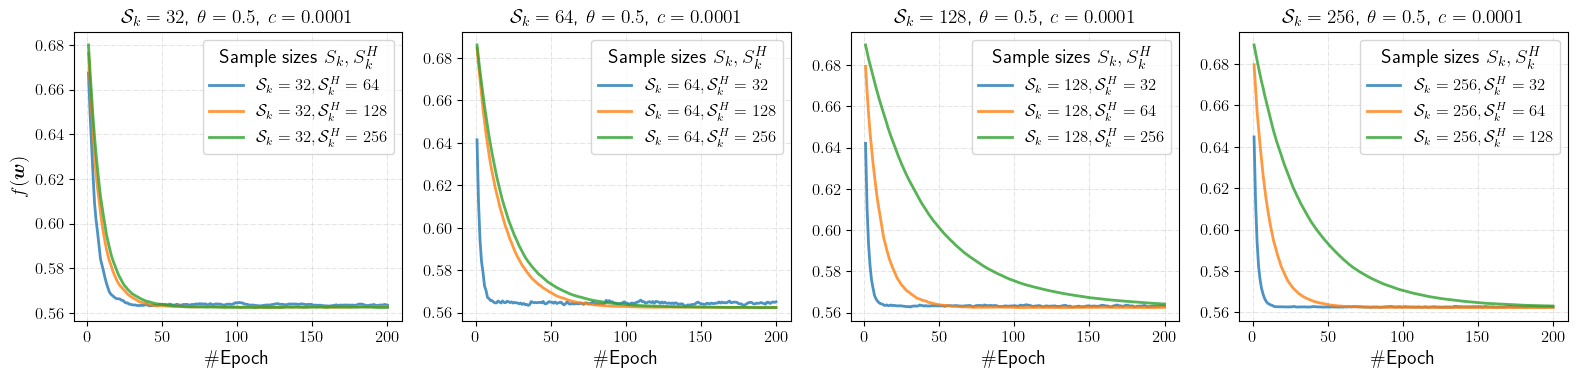

In [25]:
results = {
    32: results_diff_grad_32,
    64: results_diff_grad_64,
    128: results_diff_grad_128,
    256: results_diff_grad_256,
}

fig, ax = plt.subplots(1, 4, figsize=(16, 4))

for i, (sample_size, results_diff_grad) in enumerate(results.items()):
    for (size_grad, size_hess), (final_point, stats) in results_diff_grad.items():
        ax[i].plot(stats['epochs'], stats['losses'],
                   label=r"$\mathcal{{S}}_{{k}}={}, \mathcal{{S}}_{{k}}^{{H}}={}$".format(size_grad, size_hess),
                   linestyle='-', linewidth=2, alpha=0.8)
    ax[i].set_xlabel(r'\#Epoch')
    ax[i].set_title(r'$\mathcal{S}_k=' + str(sample_size) + r'$, $\theta=0.5$, $c=0.0001$')
    ax[i].legend(fontsize=12, title=r'Sample sizes $S_k, S_k^H$')
    ax[i].grid(True, which='both', linestyle='-.', linewidth=0.5, alpha=0.5)
    if i == 0:
        ax[i].set_ylabel(r'$f(\boldsymbol{w})$')

plt.tight_layout()
plt.savefig('subsampling_newton_diff_sample_sizes.pdf', bbox_inches='tight')
plt.show()

In [27]:
def calculate_lipschitz_constant(X, sample_indices, lambda_reg):
    X_sample = X[sample_indices]
    n_samples = X_sample.shape[0]
    L = 4 * np.linalg.norm(X_sample.T @ X_sample) / n_samples + lambda_reg
    return L


def calculate_lipschitz_constant_batch(X, sample_indices, lambda_reg, batch_size):
    n_samples = X.shape[0]
    n_batches = n_samples // batch_size
    L = 0
    for i in range(n_batches):
        batch_indices = sample_indices[i * batch_size: (i + 1) * batch_size]
        X_batch = X[batch_indices]
        L += 4 * np.linalg.norm(X_batch.T @ X_batch) / batch_size
    L += lambda_reg
    return L


sample_size_grad = sample_size_hess = 128
L = calculate_lipschitz_constant(problem.X, np.arange(problem.n), problem.lbda)
L_Sk = calculate_lipschitz_constant_batch(problem.X, np.arange(problem.n), problem.lbda, sample_size_grad)
alpha_bar_values = [0.01, 0.05, 0.1, 0.5, 1]
results_alpha_bar, results_alpha_bar_L, results_alpha_bar_L_Sk = {}, {}, {}

# TIME CONSUMING ETA 6min FOR ALL RESULTS FROM EACH ALPHA_BAR

for alpha_bar in alpha_bar_values:
    newton = SubsamplingNewton(problem, sample_size_grad, sample_size_hess, epochs=200, theta=0.5, c=1e-4,
                               alpha=alpha_bar)
    final_point, stats = newton.optimize(initial_point, tol=1e-6, use_line_search=True)
    results_alpha_bar[alpha_bar] = (final_point, stats)

for alpha_bar in alpha_bar_values:
    optimizer_fixed = SubsamplingNewton(problem, sample_size_grad, sample_size_hess, epochs=200, theta=0.5, c=1e-4,
                                        alpha=alpha_bar / L)
    _, stats_fixed = optimizer_fixed.optimize(w_init=initial_point, tol=1e-6, use_line_search=False)
    results_alpha_bar_L[alpha_bar] = stats_fixed

for alpha_bar in alpha_bar_values:
    optimizer_fixed = SubsamplingNewton(problem, sample_size_grad, sample_size_hess, epochs=200, theta=0.5, c=1e-4,
                                        alpha=alpha_bar / L_Sk)
    _, stats_fixed = optimizer_fixed.optimize(w_init=initial_point, tol=1e-6, use_line_search=False)
    results_alpha_bar_L_Sk[alpha_bar] = stats_fixed

Epoch 200: 100%|██████████| 7/7 [00:00<00:00, 96.00it/s, Loss=0.5887]


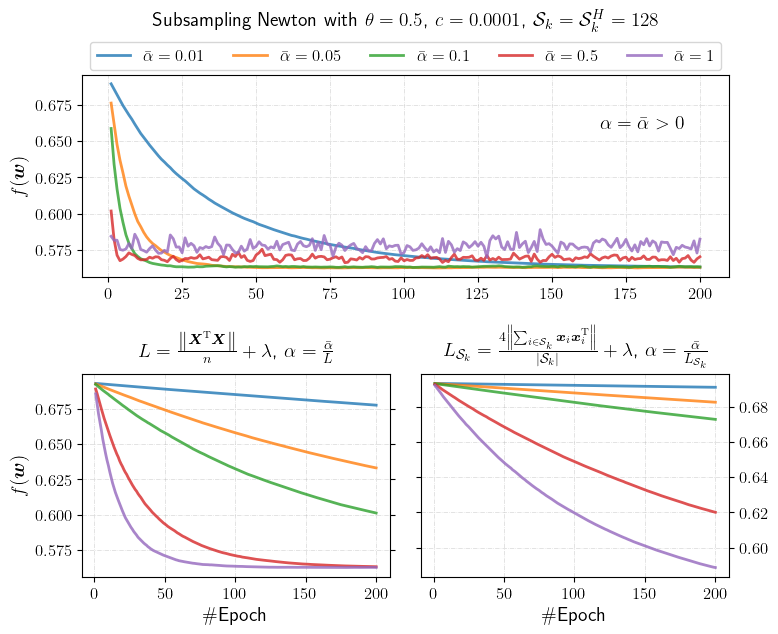

In [28]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(8, 7))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1])

ax0 = plt.subplot(gs[0, :])
for alpha, (final_point, stats) in results_alpha_bar.items():
    ax0.plot(stats['epochs'], stats['losses'],
             label=r"$\bar{{\alpha}}={}$".format(alpha),
             linestyle='-', linewidth=2, alpha=0.8)
textstr = r'$\alpha=\bar{\alpha} > 0$'
ax0.text(0.8, 0.8, textstr, transform=ax0.transAxes, fontsize=14, verticalalignment='top')
ax0.set_ylabel(r'$f(\boldsymbol{w})$')
ax0.set_title(r'Subsampling Newton with $\theta=0.5$, $c=0.0001$, $\mathcal{S}_k=\mathcal{S}_k^H=128$', fontsize=14,
              y=1.2, x=0.5)
ax0.grid(True, which='both', linestyle='-.', linewidth=0.5, alpha=0.5)

ax1 = plt.subplot(gs[1, 0])
for alpha_bar, stats in results_alpha_bar_L.items():
    ax1.plot(stats['epochs'], stats['losses'],
             label=r"$\frac{{\bar{{\alpha}}}}{{L}}={:.6f}$".format(alpha_bar / L),
             linestyle='-', linewidth=2, alpha=0.8)
ax1.set_xlabel(r'\#Epoch')
ax1.set_ylabel(r'$f(\boldsymbol{w})$')
ax1.set_title(
    r'$L=\frac{\left\|\boldsymbol{X}^{\mathrm{T}}\boldsymbol{X}\right\|}{n}+\lambda$, $\alpha=\frac{\bar{\alpha}}{L}$',
    y=1.05)
ax1.tick_params(axis='y', which='both', left=True, right=True, labelleft=True, labelright=False)
ax1.grid(True, which='both', linestyle='-.', linewidth=0.5, alpha=0.5)

ax2 = plt.subplot(gs[1, 1])
for alpha_bar, stats in results_alpha_bar_L_Sk.items():
    ax2.plot(stats['epochs'], stats['losses'],
             label=r"$\bar{{\alpha}}={}$".format(alpha_bar),
             linestyle='-', linewidth=2, alpha=0.8)
# ax2.set_ylabel(r'$f(\boldsymbol{w})$')
ax2.set_xlabel(r'\#Epoch')
ax2.set_title(
    r'$L_{\mathcal{S}_k}=\frac{4\left\|\sum_{i \in \mathcal{S}_k} \boldsymbol{x}_i \boldsymbol{x}_i^{\mathrm{T}}\right\|}{\left|\mathcal{S}_k\right|}+\lambda$, $\alpha=\frac{\bar{\alpha}}{L_{\mathcal{S}_k}}$',
    y=1.05)
ax2.tick_params(axis='y', which='both', left=True, right=True, labelleft=False, labelright=True)
ax2.grid(True, which='both', linestyle='-.', linewidth=0.5, alpha=0.5)

ax0.legend(fontsize=12, loc='upper center', bbox_to_anchor=(0., 1.1, 1., .102), ncol=7, mode='expand')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('subsampling_newton_combined.pdf', bbox_inches='tight')
plt.show()

In [29]:
alpha = 0.001
problem = pblogreg
initial_point = np.zeros(problem.d)
epochs = 200
tobe_fair_iter = 200 * problem.n

lbfgs = LBFGSOptimizer(problem.fun, problem.grad, initial_point, memory_size=5, c=1e-4, theta=0.5, verbose=True)
_, stats_lbfgs = lbfgs.solve(tolerance=1e-6, max_iterations=tobe_fair_iter)

quasi_newton = QuasiNewtonBFGSOptimizer(problem.fun, problem.grad, initial_point, c=1e-4, theta=0.5, verbose=True)
_, stats_quasi_newton = quasi_newton.solve(tolerance=1e-6, max_iterations=tobe_fair_iter)

sto_bfgs_1 = StochasticBFGS(problem, sample_size=1, epochs=epochs, theta=0.5, c=1e-4, alpha=alpha)
sto_lbfgs_1 = StochasticLBFGS(problem, sample_size=1, epochs=epochs, m=5, theta=0.5, c=1e-4, alpha=alpha)
sto_bfgs_16 = StochasticBFGS(problem, sample_size=16, epochs=epochs, theta=0.5, c=1e-4, alpha=alpha)
sto_lbfgs_16 = StochasticLBFGS(problem, sample_size=16, epochs=epochs, m=5, theta=0.5, c=1e-4, alpha=alpha)
sto_bfgs_32 = StochasticBFGS(problem, sample_size=32, epochs=epochs, theta=0.5, c=1e-4, alpha=alpha)
sto_lbfgs_32 = StochasticLBFGS(problem, sample_size=32, epochs=epochs, m=5, theta=0.5, c=1e-4, alpha=alpha)
sto_bfgs_64 = StochasticBFGS(problem, sample_size=64, epochs=epochs, theta=0.5, c=1e-4, alpha=alpha)
sto_lbfgs_64 = StochasticLBFGS(problem, sample_size=64, epochs=epochs, m=5, theta=0.5, c=1e-4, alpha=alpha)
sto_bfgs_128 = StochasticBFGS(problem, sample_size=128, epochs=epochs, theta=0.5, c=1e-4, alpha=alpha)
sto_lbfgs_128 = StochasticLBFGS(problem, sample_size=128, epochs=epochs, m=5, theta=0.5, c=1e-4, alpha=alpha)
sto_bfgs_256 = StochasticBFGS(problem, sample_size=256, epochs=epochs, theta=0.5, c=1e-4, alpha=alpha)
sto_lbfgs_256 = StochasticLBFGS(problem, sample_size=256, epochs=epochs, m=5, theta=0.5, c=1e-4, alpha=alpha)

_, stats_sto_bfgs_1 = sto_bfgs_1.optimize(initial_point, tol=1e-6, use_line_search=True)
_, stats_sto_lbfgs_1 = sto_lbfgs_1.optimize(initial_point, tol=1e-6, use_line_search=True)
_, stats_sto_bfgs_16 = sto_bfgs_16.optimize(initial_point, tol=1e-6, use_line_search=True)
_, stats_sto_lbfgs_16 = sto_lbfgs_16.optimize(initial_point, tol=1e-6, use_line_search=True)
_, stats_sto_bfgs_32 = sto_bfgs_32.optimize(initial_point, tol=1e-6, use_line_search=True)
_, stats_sto_lbfgs_32 = sto_lbfgs_32.optimize(initial_point, tol=1e-6, use_line_search=True)
_, stats_sto_bfgs_64 = sto_bfgs_64.optimize(initial_point, tol=1e-6, use_line_search=True)
_, stats_sto_lbfgs_64 = sto_lbfgs_64.optimize(initial_point, tol=1e-6, use_line_search=True)
_, stats_sto_bfgs_128 = sto_bfgs_128.optimize(initial_point, tol=1e-6, use_line_search=True)
_, stats_sto_lbfgs_128 = sto_lbfgs_128.optimize(initial_point, tol=1e-6, use_line_search=True)
_, stats_sto_bfgs_256 = sto_bfgs_256.optimize(initial_point, tol=1e-6, use_line_search=True)
_, stats_sto_lbfgs_256 = sto_lbfgs_256.optimize(initial_point, tol=1e-6, use_line_search=True)

Starting optimization!
Iteration 1:
	Current point: [ 0.14889681  0.00831454  0.08468234  0.0088207   0.06825177 -0.00720802
  0.04394682 -0.00196441  0.02387381 -0.01197104  0.02339941 -0.01093907
 -0.0004639  -0.01318568  0.00461472 -0.01182739 -0.00365116 -0.01456008
 -0.01452089 -0.03827947 -0.02558426 -0.01771164  0.01078643 -0.01330792
 -0.03644912 -0.01015342  0.00239239  0.00491015  0.01456204  0.00416179
  0.00150964 -0.0084187   0.00483896  0.00199211  0.01984225  0.02150096
  0.01642464 -0.00699556 -0.00418978 -0.01167711 -0.01448169 -0.02343986
 -0.00522339  0.0068754   0.01232907  0.03769752  0.03257776  0.02246014
  0.02725938  0.03510429]
	Function value: 0.65760693672866
	Gradient norm: 0.13799649425013616
Iteration 2:
	Current point: [ 3.91642931e-01 -6.44011955e-02  1.86356212e-01 -5.35768525e-02
  1.45136606e-01 -8.41463858e-02  8.60283159e-02 -5.04869082e-02
  4.23833589e-02 -6.18003943e-02  6.10341911e-02 -4.02850062e-02
 -1.26743275e-03 -3.79646450e-02  2.11580079

Epoch 200: 100%|██████████| 3/3 [00:00<00:00, 190.72it/s, Loss=0.6346]


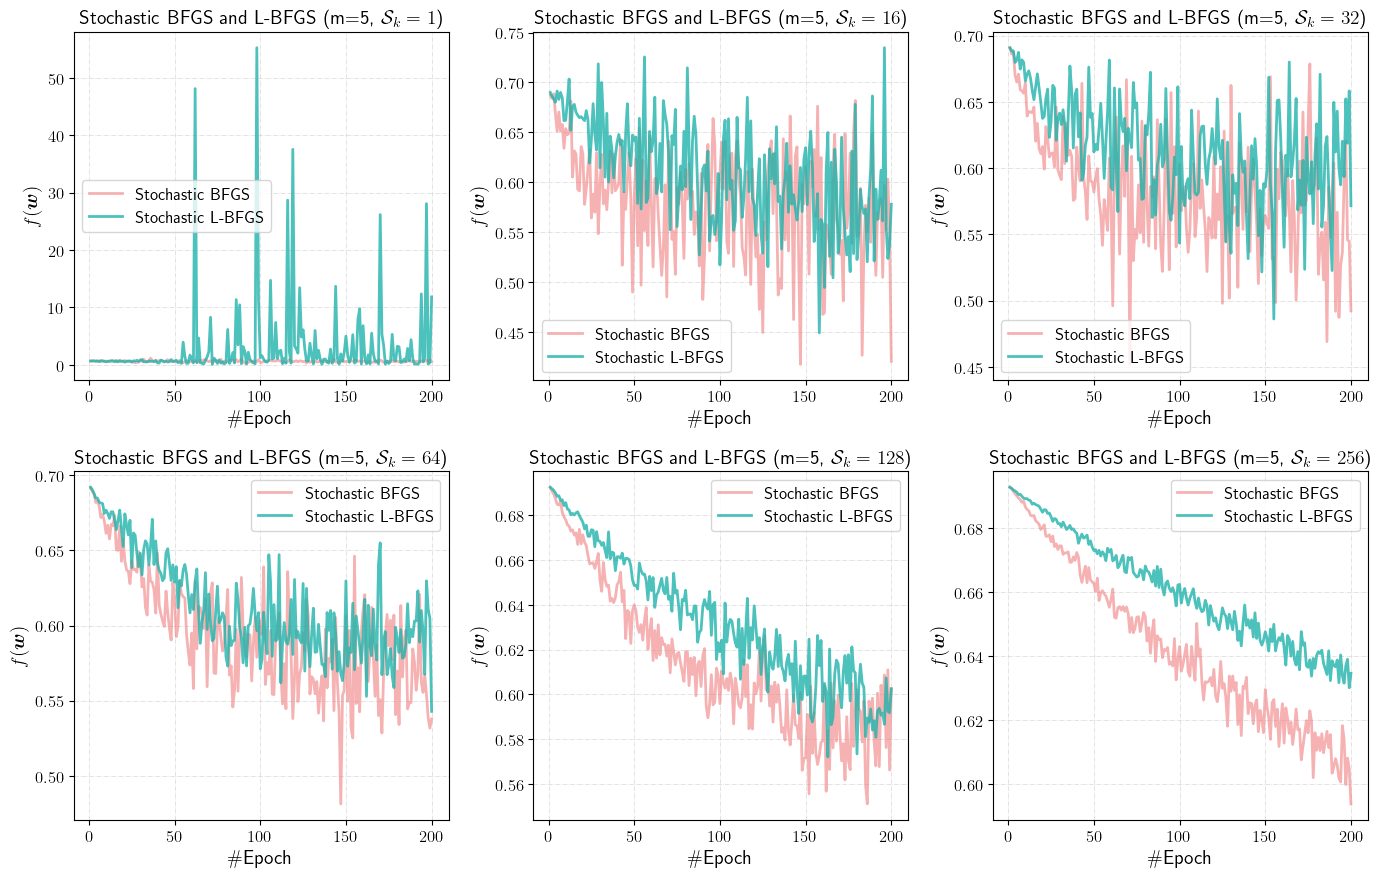

In [49]:
fig, ax = plt.subplots(2, 3, figsize=(14, 9))

for i, (sample_size, stats_sto_bfgs) in enumerate(
        [(1, stats_sto_bfgs_1), (16, stats_sto_bfgs_16), (32, stats_sto_bfgs_32), (64, stats_sto_bfgs_64),
         (128, stats_sto_bfgs_128), (256, stats_sto_bfgs_256)]):
    ax[i // 3, i % 3].plot(stats_sto_bfgs['epochs'], stats_sto_bfgs['losses'],
                           label='Stochastic BFGS', linestyle='-', linewidth=2, alpha=0.6, color='lightcoral')
    ax[i // 3, i % 3].set_xlabel(r'\#Epoch')
    ax[i // 3, i % 3].set_ylabel(r'$f(\boldsymbol{w})$')
    ax[i // 3, i % 3].set_title(r'Stochastic BFGS and L-BFGS (m=5, $\mathcal{{S}}_k={}$)'.format(sample_size))
    ax[i // 3, i % 3].legend(fontsize=12)
    ax[i // 3, i % 3].grid(True, which='both', linestyle='-.', linewidth=0.5, alpha=0.5)

for i, (sample_size, stats_sto_lbfgs) in enumerate(
        [(1, stats_sto_lbfgs_1), (16, stats_sto_lbfgs_16), (32, stats_sto_lbfgs_32), (64, stats_sto_lbfgs_64),
         (128, stats_sto_lbfgs_128), (256, stats_sto_lbfgs_256)]):
    ax[i // 3, i % 3].plot(stats_sto_lbfgs['epochs'], stats_sto_lbfgs['losses'],
                           label='Stochastic L-BFGS', linestyle='-', linewidth=2, alpha=0.8, color='lightseagreen')
    ax[i // 3, i % 3].set_xlabel(r'\#Epoch')
    ax[i // 3, i % 3].set_ylabel(r'$f(\boldsymbol{w})$')
    ax[i // 3, i % 3].set_title(r'Stochastic BFGS and L-BFGS (m=5, $\mathcal{{S}}_k={}$)'.format(sample_size))
    ax[i // 3, i % 3].legend(fontsize=12)
    ax[i // 3, i % 3].grid(True, which='both', linestyle='-.', linewidth=0.5, alpha=0.5)

plt.tight_layout()
plt.savefig('stochastic_bfgs_vs_quasi_newton_batch_sizes.pdf', bbox_inches='tight')
plt.show()

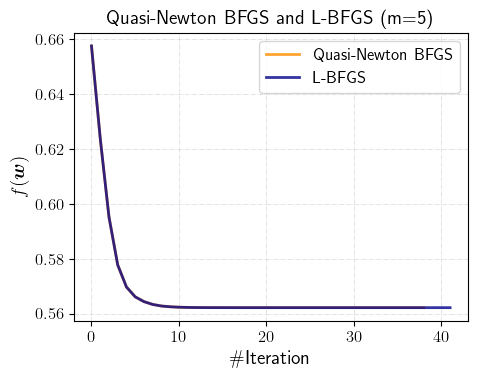

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.plot(stats_quasi_newton['function_values'], label='Quasi-Newton BFGS', linestyle='-', linewidth=2, alpha=0.8,
        color='darkorange')
ax.plot(stats_lbfgs['function_values'], label='L-BFGS', linestyle='-', linewidth=2, alpha=0.8, color='darkblue')
ax.set_xlabel(r'\#Iteration')
ax.set_ylabel(r'$f(\boldsymbol{w})$')
ax.set_title(r'Quasi-Newton BFGS and L-BFGS (m=5)')
ax.legend(fontsize=12)
ax.grid(True, which='both', linestyle='-.', linewidth=0.5, alpha=0.5)
plt.tight_layout()
plt.show()

# Part 3: Binary classification